[Original Notebook Here!](https://colab.research.google.com/drive/1QF40xb7qqraKYBwJpOyZNVXq2AepJPUM#scrollTo=KuOUnlDpSYdw)

Welcome to my multi agent RAG application for dog breed information! Here is a RAG application with embedded text information from over 70 breeds! I use LangGraph to organize the structure of the information retrieval process, and use states to pass the correct information from a dictionary into the appropriate nodes. [Check out my other notebook](https://colab.research.google.com/drive/1by5UTMttZwW6xGGo89hmVNu2b90V3-HV#scrollTo=qpSPqD1AcNiH) that shows the full process, starting from gathering the text data to setting up a basic RAG, all in one go.


This notebook is broken down into seperate cells for clarity, but you can click on "Runtime" and select "Run All". Make sure to change the runtime type to use a GPU, such as the free "T4" provided by Google Colab. **IMPORTANT**: You will need an [API key from Tavily](https://tavily.com) to run this notebook. The free tier offers 1000 API calls. Furthermore, the key in this notebook further down is stored and retrieved as a Colab Secret. If you are not using Google Colab, you will need to retrieve your API Key in a different manner, such as with dot_env or importing a config file (or directly if its for your eyes only).


Google Colab notebooks erases anything installed and uploaded/downloaded after a runtime is closed or disconnected. This means you have to download the model and other data each time. As a result, in this Google Colab notebook I use a 3 billion parameter version of Ollama 3.2 to provide a balance between performance and time dowloading the model. If you are running this notebook locally or somewhere else and you have access to a GPU, you wont have to download the model and data each time so feel free to try it with a [larger Ollama model.](https://ollama.com/library)

The first two cells install all of the necessary packages, downloads the vector database, and sets up OLlama for use. Google Colab comes already with some packages installed. *If you are not using Colab, you will need to install the rest of the packages as well.*

In [1]:
#This cell installs the necessary python libraries, installs Ollama and boots it up, and loads an Ollama model ready for use. Here
%%capture
!pip install langgraph langchain_ollama
!curl https://ollama.ai/install.sh | sh
!nohup ollama serve &  #starts the Ollama server in the background using nohup.
!ollama pull llama3.2:3b
!pip install sentence-transformers chromadb
%pip install -qU "langchain-community>=0.2.11"



In [2]:
from sentence_transformers import SentenceTransformer
import chromadb
import os
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from google.colab import userdata
from langchain_community.tools import TavilySearchResults
import os
import gdown

#Downloads the vector database
url = "https://drive.google.com/drive/folders/17riCAq2S53-HHfVED2IKIRasvQwjbku3?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

#By default, Ollama serves on 127.0.0.1:11434, which is the localhost address and port
os.environ['OLLAMA_HOST'] = '127.0.0.1:11434'

#If you want to change other parameters for Ollama you may do so here, but the default is good
llm = ChatOllama(
    model="llama3.2:3b",
    temperature=0,

)


In the following four cells, the six functions will be used as part of nodes. Each function will either be a single node, or go with a conditional edge (not a regular edge). LangGraph uses nodes and edges to structure a project, where the node dictates what function to run while the edge dictates which node should come next. There is an image created near the end that helps visualize this structure.

The "Embedding" function is the start node. It will receive the input; in this case the user question. In order to find the answer in the vetor database, it embeds the question into a numerical vector. Then it searches the vector database for a numerical vector that is similar in value (which represents semantic similarity). Next it outputs the most similar vector (or multiple vectors) as readable text, as a python string. The string is finally appended to the 'info' key. More on that later.

Binary_Response is a function that uses an LLM to decide whether the question will be answered by the output from the vector store. It uses both the original question and the output form the 'Embedding' function. As the name implies, it will always only output 2 options: "YES" or "NO". The result will be passed to a conditional edge next.

In [3]:

def Embedding(state):
    info = state['info']
    # Initialize the model
    smodel = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # Initialize the chromadb client and collection
    client = chromadb.PersistentClient(path="dog")
    collection = client.get_or_create_collection("dogdb")

    question = info[0].content
    #print(question)

    query = [
        {'question': f"{question}"},
    ]
    query_embeddings= smodel.encode(query)
    embedding_results = collection.query(
        query_embeddings=query_embeddings,
        n_results=3 # how many results to return. You can change this, but three works well
    )
    print(embedding_results)
    embedding_results = str(embedding_results)
    #Prints out the embeddign results. If you only want inference, cancel this line
    return {"info": [embedding_results]}

def Binary_Response(state):
    info = state['info']
    question = info[0].content
    embedding_results = info[1].content

    prompt = [{"role": "user", "content": f"""You are a binary (Yes/No) grader assessing relevance of a retrieved document from a vector store to a user question. The topic is information about dog breeds.
        I have provided a retrieved embedding with metadata. Here numbered are the most iportant rules:
        1. There needs to be similarity between the dog breed asked and the dog breed in the 'metadatas'or 'documents' section of the retrieved document. it doesnt have to be exact, but the spirit of the breed mentioned has to match.
        2. The question about the breed is answered by the actual body text named "document" of the retrieved embedding.
        You will only ever answer yes or no. Those are the only two words you will answer \n
        Here is the retrieved document: \n\n {embedding_results} \n\n
        Here is the user question: {question} \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. Your only word should be "YES" or "NO"."""}]
    #print(prompt)
    conditional_results = llm.invoke(prompt).content
    print(conditional_results)

    return {"info": [conditional_results]}




I mentioned a conditional edge above. A conditional edge is an edge that can branch off into one of multiple nodes, while the normal edge only has one option. From the "Binary_Response" function, we always recieve either "YES" or "NO". If "YES", this means that the question is answered by the embedding output, thus we can simply send the embedding output and the question to an LLM to clean up the final output. That node is "LLM_Output".  If "NO", this means that the question was not answered by the embedding output, so we send it to the "Tavily_Search" node instead. Tavily is a tool that uses an API call to search a question online and return it as a python string.  

The "next_node" function is here in case the LLM outputs "YES" or "NO" with different capitalizations of letters. If it outputs something besides this, it will return "LLM Conditional Decision Error" to let me know there is something wrong at "Binary_Response" node.

In [4]:
def next_node(state):
    info = state['info']
    input_2 = info[-1].content
    #print(input_2)

    if input_2 == "YES" or input_2 == "Yes" or input_2 == "yes":
        return "LLM_Output"
    if input_2 == "No" or input_2 == "no" or input_2 == "NO":
        return "Tavily_Search"
    else:
        return "LLM Conditional Decision Error"

The next cell is the result from the conditional edge.

"LLM_Output" is straightforward; if it got sent to this node, the script will run the "LLM_Output" function. It simply passes the "embedding_results" and the "question" values from the "info" dictionary into an LLM prompt to produce the final answer in a clean manner. The RAG application is finished if it goes in this direction.

"Tavily_Search" uses a search engine that returns a python string for use via an API call. In order to use it you will need an account with Tavily first. Then you can use a LangChain wrapper to easily gather and the results form Tavily. The parameters from TavilySearchResults allow you to change several options, mainly how many results to produce. More options means more information but higher API usage. Finally the output from "Tavily_Search" is ran through a for loop in order to clean the results that will be passed through an LLM to answer with this information.

In [5]:
def LLM_Output(state):
    info = state['info']
    question = info[0].content
    #print(question)
    embedding_results = info[1].content
    #print(embedding_results)
    prompt = [{"role": "user", "content": f"""After the colon is an embedding with metadata and ID's, with information about dogs, then a question about the given text. Please answer the question based off the text, and do not talk about the documentation:
    text - {embedding_results}
    question - {question}
    Respond in a friendly manner; you are an informational about dogs. Finally do not reference the text itself, such as 'basd off the text', or anything of that sort"""}]
    final_response = llm.invoke(prompt).content
    print(final_response)
    return {"info": [final_response]}

def Tavily_Search(state):
    #IMPORTANT: The line below is to load the Tavily API_KEY in Google Colab only.
    TAVILY_SECRET = userdata.get('TAVILY_KEY')


    if not os.environ.get("TAVILY_API_KEY"):
        os.environ["TAVILY_API_KEY"] = TAVILY_SECRET
    info = state['info']
    input_3 = info[0].content
    #print(input_3)
    tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=False,
    include_images=True)
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
    results = tool.invoke({"query": input_3})
    print(results)
    content_list = []
    # Iterate through the results and print the content portions
    for i, result in enumerate(results):
        content_list.append(result['content'])
    formatted_results = "|| ".join(content_list)

    # Print the formatted results
    #print(formatted_results)

    # Return the formatted results if needed
    return {"info": [formatted_results]}



The final function below simply processes the results from the "Tavily_Search" node/function by putting these results into an LLM prompt along the question to get the final output, similar to "LLM_Output" previously.

In [6]:
def Tavily_LLM_Output(state):
    info = state['info']
    tavily_output = info[-1].content
    #print(tavily_output)
    question = info[0].content

    prompt = [{"role": "user", "content": f"""You are a Large Language Model (LLM). Please answer the question based off the following text:
        text - {tavily_output}
        question - {question}
        If the question is not answered by the text, use your training to answer the question. Finally do not reference the text itself, such as 'basd off the text', or anything of that sort"""}]
    final_response = llm.invoke(prompt).content
    print(final_response)
    return {"info": [final_response]}

Next up is the structure of the Multi Agent RAG application.  Before we had been simply defining the actions of each step.

````
class AgentState(TypedDict):
    info: Annotated[list, add_messages]
````
This code defines a state (AgentState) using TypedDict, specifying a structure for the state that will be passed through all nodes in the LangGraph. A state is a snapshot of where your LLM process is; in my case I use it to store information about certain variables to be used at diffrerent points. Another common use is to store conversation data for chatbots. The class above declares that the state will have an 'info' key containing a list. There can be other keys if needed. The Annotated wrapper with 'add_messages' provides metadata about how this list should be handled, indicating that new messages should be appended to it. When using StateGraph from LangGraph, each node function must receive and return this state structure.

After that, you create an instance of the AgentState class, then establish the worknode and edges logic. The best way to understand this portion is to see the image displayed when you run the cell below. Basically you assign a name then a function (already defined above) to each node. The edges connect two nodes based off their names, and the conditional edge connects one node with multiple possible outgoing nodes, using a function to decide the logic of which one to choose. Finally, call the compile() method.




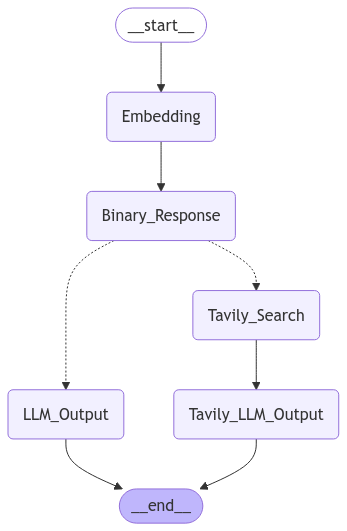

In [7]:
class AgentState(TypedDict):
    info: Annotated[list, add_messages]


# Define a Langchain graph
workflow = StateGraph(AgentState)

#The first parameter is the name of the node, a name to be used in the edges. The second is the function that will be ran at each respective node.
workflow.add_node("Embedding", Embedding)
workflow.add_node("Binary_Response", Binary_Response)
workflow.add_node("Tavily_Search", Tavily_Search)
workflow.add_node("Tavily_LLM_Output",Tavily_LLM_Output)
workflow.add_node("LLM_Output", LLM_Output)

workflow.add_edge(START, "Embedding")
workflow.add_edge("Embedding", "Binary_Response")
workflow.add_conditional_edges("Binary_Response", next_node, {"Tavily_Search":"Tavily_Search", "LLM_Output":"LLM_Output"})
workflow.add_edge("Tavily_Search", "Tavily_LLM_Output")
workflow.add_edge("Tavily_LLM_Output", END)
workflow.add_edge("LLM_Output", END)


RAG = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(RAG.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



The very last cell is to run the Multi Agent RAG for inference! Input a question and invoke that question as the first item in the 'info' key. If you want more information about the process, print 'surpress_additional_info'. Otherwise don't change anything so that the only thing that gets printed is what's specified in the node functions to print.

In [9]:
user_input = input("Ask Dog Question here:  ")
supress_additional_info = RAG.invoke({"info": [user_input]}) #Google colab automatically prints the last line. If you want the metadata simply do RAG.invoke({"info": [user_input]})
#As mentioned above, "YES" means the an embedding from the vectore database will be used. "NO" means that the vector database will not be used, and instead will go the Tavily search route

Ask Dog Question here:  How big do labradors get?
{'ids': [['Labrador-Retriever4_21', 'Labrador-Retriever3_8', 'Labrador-Retriever4_10']], 'embeddings': None, 'documents': [['It is worth noting that the size of a Labrador Retrievers as described by the Kennel Club are to be used as guidelines only and that Labs can be smaller or larger they can also weigh a little more or a little less than stated in their breed standard which is to be used as a guideline only.', 'Labs vary in size from 22 to 24.5 inches tall at the shoulder and weigh between 55 and 90 pounds. Females are generally slightly smaller and more lightly built than male Labrador Retrievers. Bench or English Labs are bigger than field labs, so that’s also something to consider when buying from a breeder.', 'The Labrador Retriever is a strongly built medium to large size dog that is broad and deep through the chest and ribs. They possess strong and compact webbed feet which are perfect for the hours Labrador Retrievers general